In [29]:
import os
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from rasterio.plot import show


In [30]:
# Paths to images and labels
data_dir = r"C:\Users\Eman\Downloads\images-20250217T060743Z-001\images"
labels_dir = r"C:\Users\Eman\Downloads\labels-20250217T060744Z-001\labels"


In [31]:
# Load TIFF images (12-band) and apply min-max normalization
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)  # Shape: (12, 128, 128)
        image = np.transpose(image, (1, 2, 0))  # Convert to (128, 128, 12)

    # Min-max normalization per channel
    min_val = np.min(image, axis=(0, 1), keepdims=True)
    max_val = np.max(image, axis=(0, 1), keepdims=True)

    normalized_image = (image - min_val) / (max_val - min_val + 1e-7)
    return normalized_image


In [32]:
# Normalize label images
def load_label(label_path):
    label = tf.keras.preprocessing.image.load_img(label_path, color_mode="grayscale")
    label = np.array(label, dtype=np.uint8)
    label = (label > 0).astype(np.int32)
    return label

# Get sorted lists of image and label file paths
image_paths = sorted(glob(os.path.join(data_dir, "*.tif")))
label_paths = sorted(glob(os.path.join(labels_dir, "*.png")))


In [33]:
# Split dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

In [34]:
# Prepare dataset for training
def preprocess_data(image_paths, label_paths):
    images = np.array([load_image(p) for p in image_paths])
    labels = np.array([load_label(p) for p in label_paths])
    labels = np.expand_dims(labels, axis=-1)
    return images, labels

train_images_np, train_labels_np = preprocess_data(train_images, train_labels)
test_images_np, test_labels_np = preprocess_data(test_images, test_labels)
train_labels_np = tf.image.resize(train_labels_np, (64, 64))
test_labels_np = tf.image.resize(test_labels_np, (64, 64))


In [35]:
# Fine-Tune a Pretrained Model (MobileNetV2 as Encoder)
def build_finetuned_unet(input_shape=(128, 128, 12)):
    # Load a pre-trained MobileNetV2 encoder
    base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

    # Extend it to 12-band images using Conv2D
    input_layer = layers.Input(shape=input_shape)
    processed_input = layers.Conv2D(3, (1, 1), activation="relu", padding="same")(input_layer)

    # Pass through pre-trained encoder
    encoder_output = base_model(processed_input)

    # Decoder with upsampling layers
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(encoder_output)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)

    output_layer = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Freeze encoder for initial training
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    return model


In [36]:
# Initialize and train the model
finetuned_model = build_finetuned_unet()
finetuned_model.summary()
finetuned_model.fit(train_images_np, train_labels_np, epochs=30, batch_size=8, validation_data=(test_images_np, test_labels_np))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 3)         │              39 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,949,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 1)           │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,594,728 (21.34 MB)

 Trainable params: 3,336,744 (12.73 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.6040 - loss: 0.6718 - val_accuracy: 0.7599 - val_loss: 0.5362
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.7066 - loss: 0.5345 - val_accuracy: 0.7609 - val_loss: 0.4140
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.7024 - loss: 0.4484 - val_accuracy: 0.7823 - val_loss: 0.3737
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.7530 - loss: 0.4107 - val_accuracy: 0.8162 - val_loss: 0.3461
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8180 - loss: 0.3603 - val_accuracy: 0.8330 - val_loss: 0.3390
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.8364 - loss: 0.3364 - val_accuracy: 0.8461 - val_loss: 0.3159
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.8585 - loss: 0.2982 - val_accuracy: 0.8498 - val_loss: 0.3105
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.8554 - loss: 0.2941 - val_accuracy: 

In [37]:
# Custom IoU metric
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.int32)
    y_true = tf.cast(y_true, tf.int32)

    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32)) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou


In [38]:
# Custom F1-score metric
def f1_score_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.int32)
    y_true = tf.cast(y_true, tf.int32)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1

In [39]:
# Unfreeze some encoder layers and continue fine-tuning
for layer in finetuned_model.layers:
    layer.trainable = True

finetuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                        loss="binary_crossentropy",
                        metrics=["accuracy", iou_metric, f1_score_metric])

finetuned_model.fit(train_images_np, train_labels_np, epochs=30, batch_size=8, validation_data=(test_images_np, test_labels_np))


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.9346 - f1_score_metric: 0.9002 - iou_metric: 0.8215 - loss: 0.1072 - val_accuracy: 0.8649 - val_f1_score_metric: 0.7205 - val_iou_metric: 0.5652 - val_loss: 0.3498
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.9392 - f1_score_metric: 0.9132 - iou_metric: 0.8427 - loss: 0.0994 - val_accuracy: 0.8640 - val_f1_score_metric: 0.7183 - val_iou_metric: 0.5626 - val_loss: 0.3518
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9447 - f1_score_metric: 0.9182 - iou_metric: 0.8507 - loss: 0.0894 - val_accuracy: 0.8635 - val_f1_score_metric: 0.7187 - val_iou_metric: 0.5630 - val_loss: 0.3561
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9416 - f1_score_metric: 0.9167 - iou_metric: 0.8492 - loss: 0.0944 - val_accuracy: 0.8631 - val_f1_score_metric: 0.7184 - val_iou_metric: 0.5626 - val_loss: 0.3602
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9393 - f1_sco

In [40]:
# Evaluate on the test set
test_loss, test_accuracy, test_iou, test_f1 = finetuned_model.evaluate(test_images_np, test_labels_np, batch_size=8)

# Print evaluation metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8673 - f1_score_metric: 0.6924 - iou_metric: 0.5321 - loss: 0.4183
Test Loss: 0.4237
Test Accuracy: 0.8631
Test IoU: 0.5583
Test F1 Score: 0.7147


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


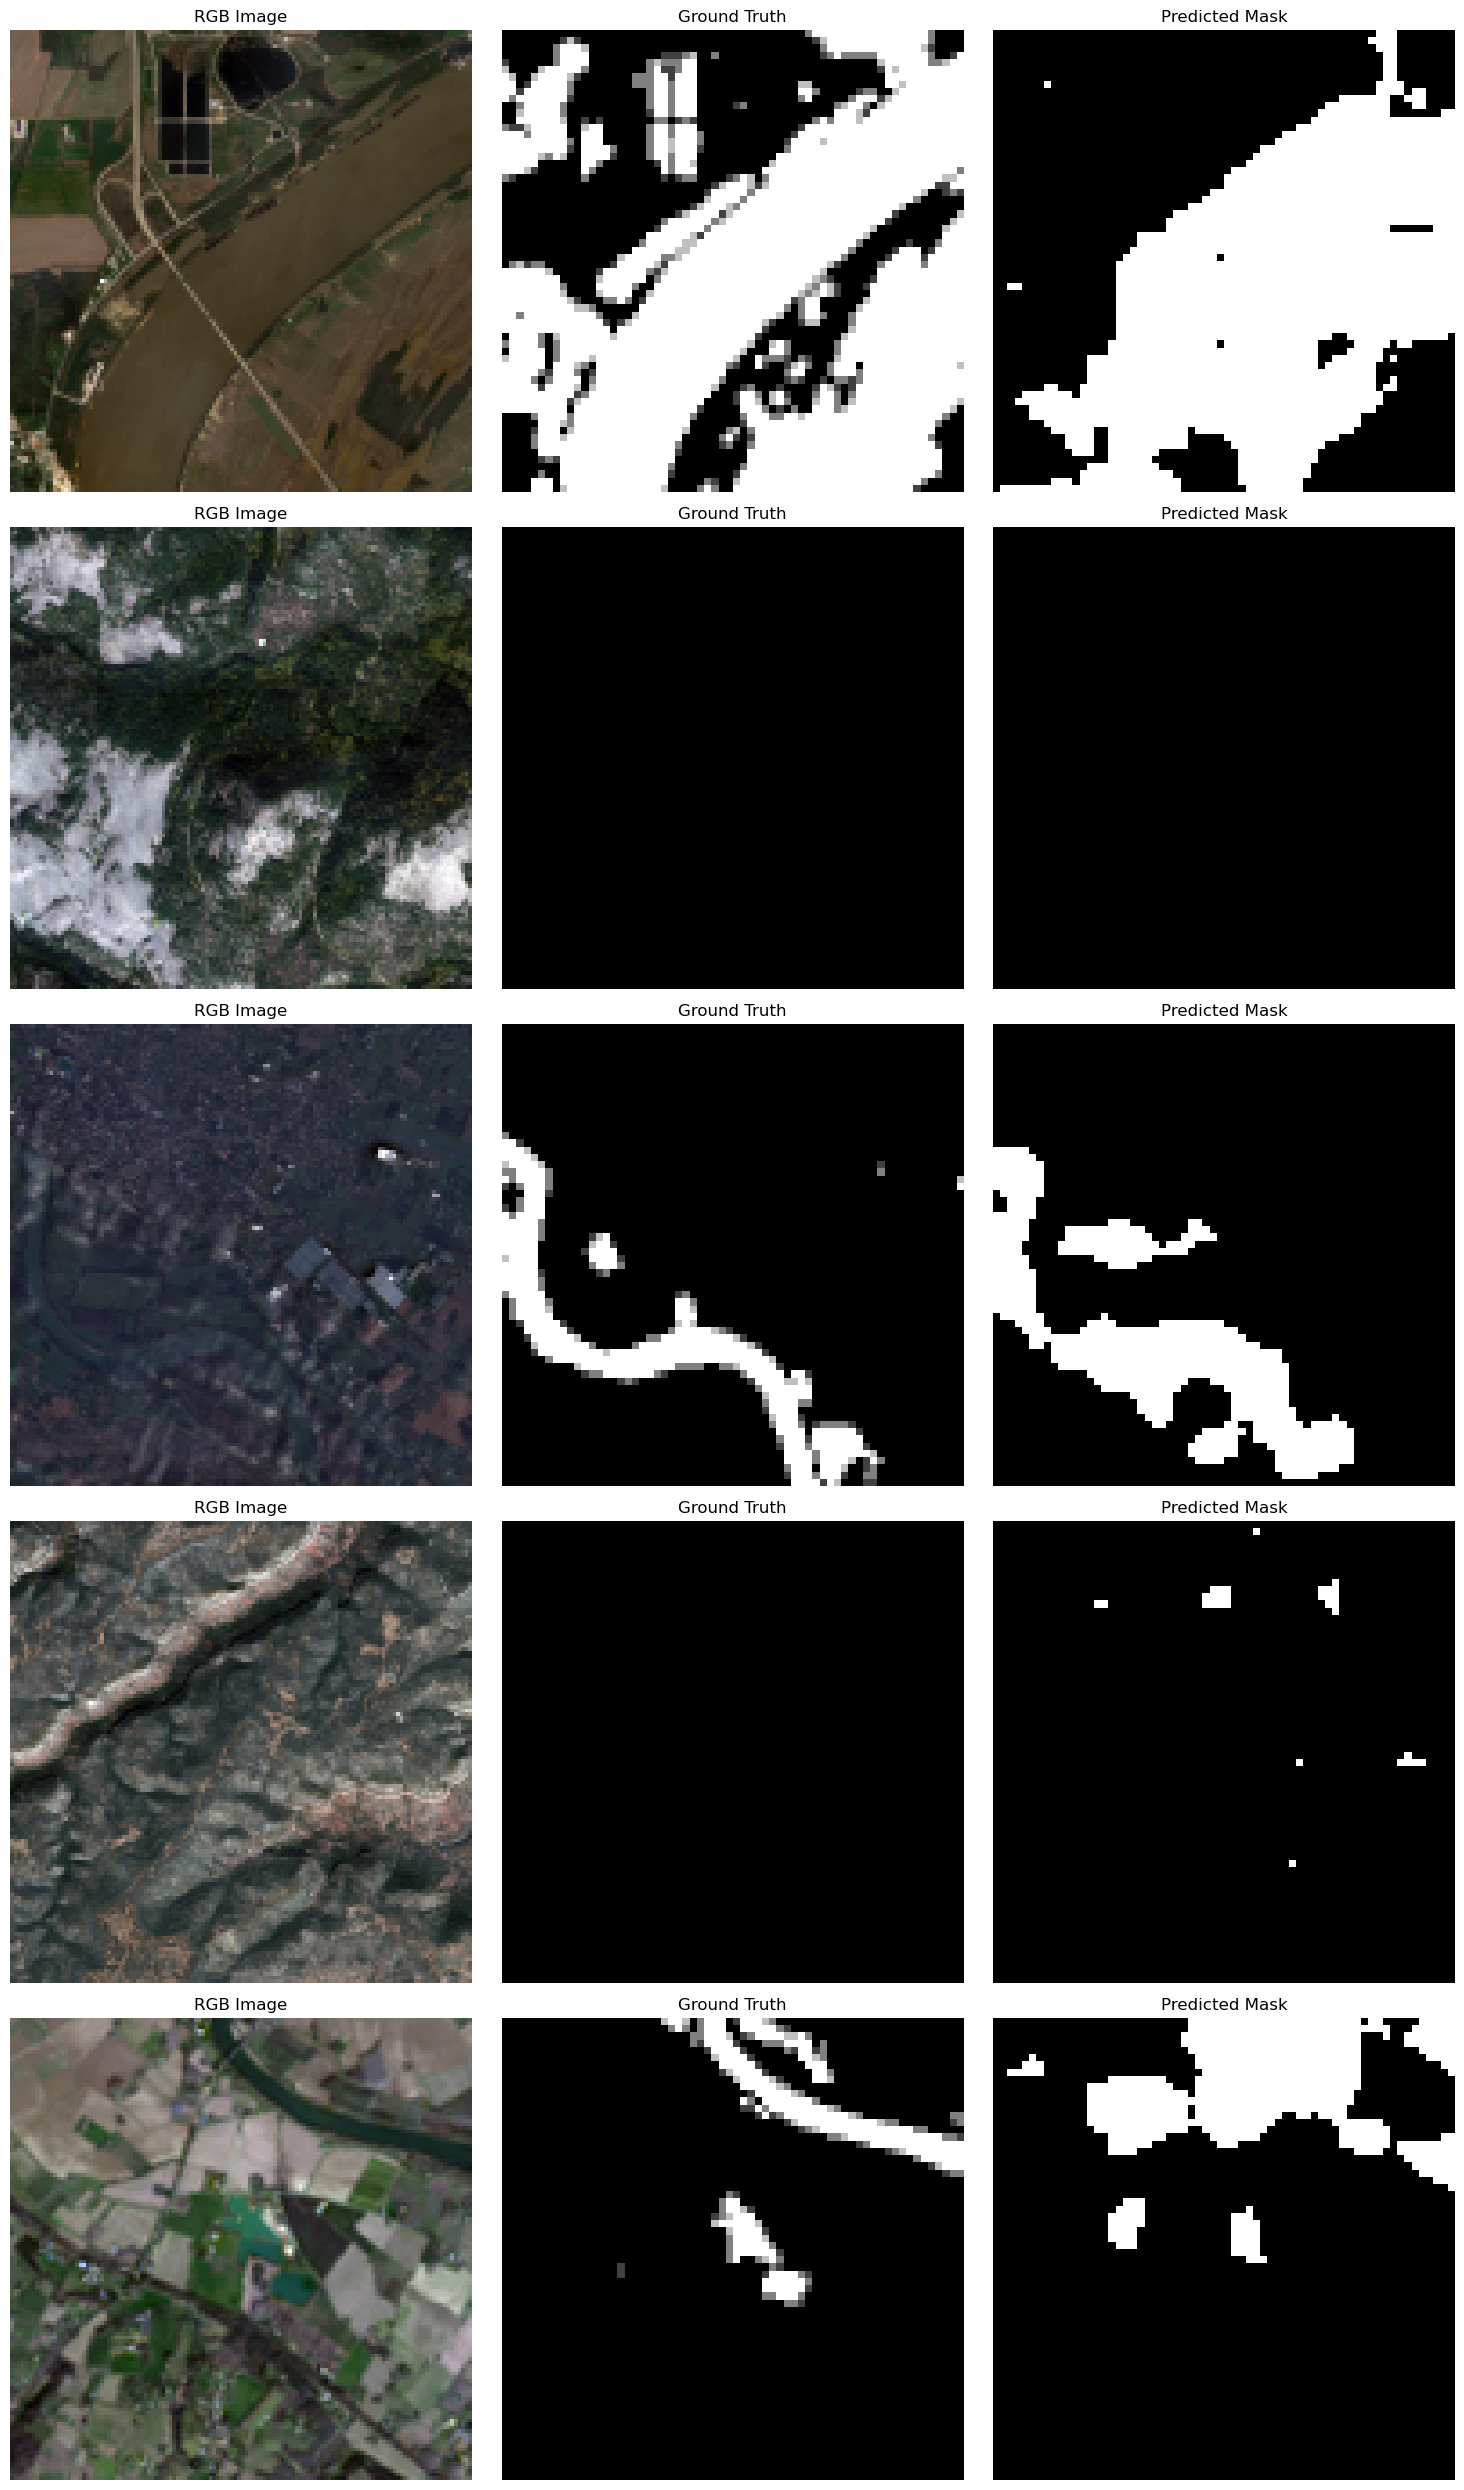

In [60]:
# Predict and evaluate
predictions = (finetuned_model.predict(test_images_np) > 0.5).astype(np.int32)

# Function to visualize RGB + ground truth + predictions
def visualize_predictions_rgb(model, X_test, Y_test, num_samples=5, rgb_bands=(4, 3, 2)):
    plt.figure(figsize=(15, num_samples * 5))
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_mask = Y_test[idx]
        rgb_image = img[..., [rgb_bands[0]-1, rgb_bands[1]-1, rgb_bands[2]-1]]
        rgb_image = np.clip((rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min()), 0, 1)
        pred_mask = model.predict(img[np.newaxis, ...])[0, ..., 0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(rgb_image)
        plt.title("RGB Image")
        plt.axis("off")
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions_rgb(finetuned_model, test_images_np, test_labels_np)


In [62]:
# Save the trained model
finetuned_model.save("water_segmentation_model.h5")